In [142]:
#visualization and exploratory data analysis library
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data Preprocessing library
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


#Model Implementation library
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.optimizers import SGD
from keras.optimizers import Nadam
from xgboost import XGBClassifier
import tensorflow as tf
#Model Analysis
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report,f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

tf.config.run_functions_eagerly(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
dataset = pd.read_csv("/content/drive/MyDrive/Smart_grid_implementation/smart_grid_stability_augmented.csv")

In [119]:
dataset

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


**Predictive features:**

**'tau1' to 'tau4':** the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);

**'p1' to 'p4':** nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);

**'g1' to 'g4':** price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');

**Dependent variables:**

**'stab':** the maximum real part of the characteristic differentia equation root (if positive, the system is linearly unstable; if negative, linearly stable);

**'stabf':** a categorical (binary) label ('stable' or 'unstable').
As there is a direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' will be dropped and 'stabf' will remain as the sole dependent variable.

In [120]:
#converting stabf from categorical to numerical (unstable: 0, stable: 1)
data_conversion = {'unstable': 0, 'stable': 1}
dataset['stabf'] = dataset['stabf'].replace(data_conversion)
print(dataset)

           tau1      tau2      tau3      tau4        p1        p2        p3  \
0      2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1      9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2      8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3      0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4      3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   
...         ...       ...       ...       ...       ...       ...       ...   
59995  2.930406  2.376523  9.487627  6.187797  3.343416 -1.449106 -0.658054   
59996  3.392299  2.954947  1.274827  6.894759  4.349512 -0.952437 -1.663661   
59997  2.364034  8.776391  2.842030  1.008906  4.299976 -0.943884 -1.380719   
59998  9.631511  2.757071  3.994398  7.821347  2.514755 -0.649915 -0.966330   
59999  6.530527  4.349695  6.781790  8.673138  3.492807 -1.532193 -1.390285   

             p4        g1        g2        g3      

# **Finding correlated values**

Here we will find correlation between dependent variables and other variables

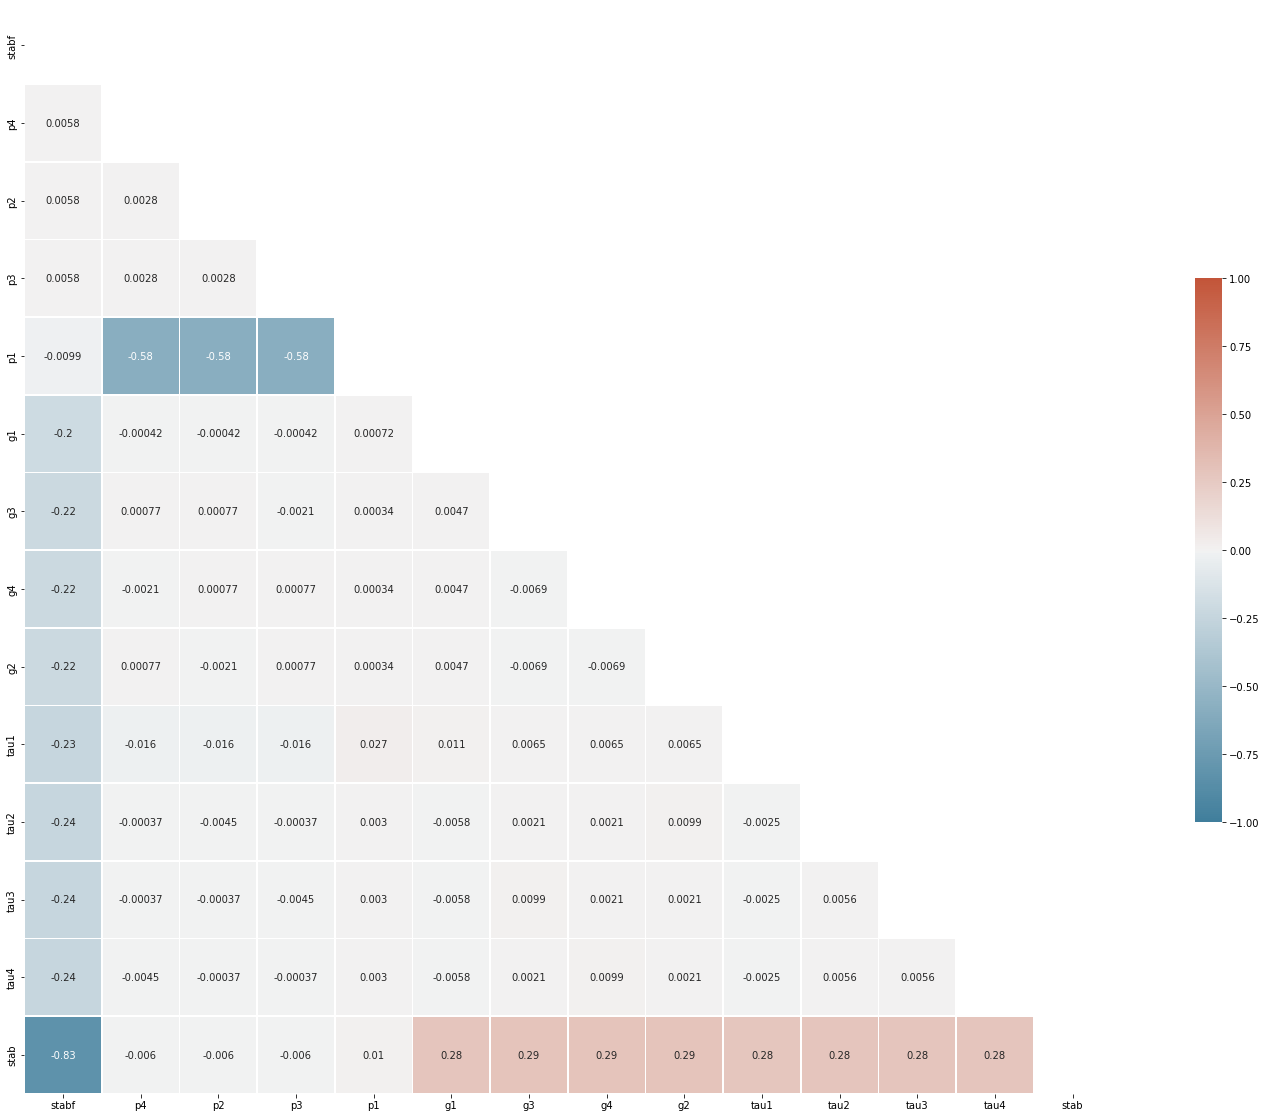

In [121]:
#finding most correlated_values
most_correlated_values = dataset.corr().nlargest(14,"stabf")["stabf"].index #index of mostly correlated values
correlated_values = dataset[most_correlated_values].corr() #values
#generate a mask for the upper triangle
mask = np.zeros_like(correlated_values)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(correlated_values, mask=mask, cmap=cmap,vmin=-1,vmax=1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})        

In [122]:
print(f'Split of "unstable" (0) and "stable" (1) observations in the original dataset:')
print(dataset['stabf'].value_counts(normalize=True))

Split of "unstable" (0) and "stable" (1) observations in the original dataset:
0    0.638
1    0.362
Name: stabf, dtype: float64


In [124]:
#input
x= dataset.iloc[:, :12] #for neural network
X = dataset.drop(['stab', 'stabf'], axis = 1) #for classification task

#output
y = dataset.iloc[:, 13] #for neural network
Y = dataset.stabf #for classification task

# **Classification**

In [125]:
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size=0.3,shuffle=True)

In [127]:
clf = XGBClassifier()
clf.fit(X_train, Y_train)

XGBClassifier()

In [129]:
model_acc=[]
model_precision=[]
model_recal=[]
model_f1=[]
model_nam=[]
model_confusion=[]

In [130]:
pred_dt = clf.predict(X_test)
clf.score(X_test, Y_test)
Y_pred=clf.predict(X_test)
score= accuracy_score(Y_test,Y_pred)
model_precision.append(precision_score(Y_test,Y_pred,average='weighted'))
model_recal.append(recall_score(Y_test,Y_pred,average='weighted'))
model_f1.append(f1_score(Y_test,Y_pred,average='weighted'))
print(f'Accuracy: {round(score*100,2)}%')
model_acc.append(score)
model_nam.append("XGB")
confusion_matrix(Y_test,Y_pred, labels=[0,1]) 

Accuracy: 93.24%


array([[11135,   366],
       [  850,  5649]])

In [131]:
print(classification_report(Y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11501
           1       0.94      0.87      0.90      6499

    accuracy                           0.93     18000
   macro avg       0.93      0.92      0.93     18000
weighted avg       0.93      0.93      0.93     18000



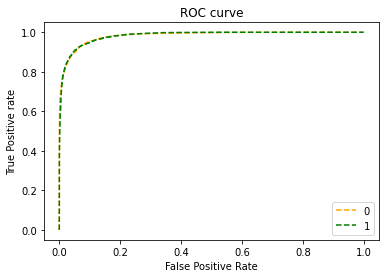

In [132]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
y_pred_proba=clf.predict_proba(X_test)

fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, y_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='0')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='1')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Binaryclass ROC',dpi=300); 

# **Neural Network**

In [133]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2)

In [134]:
x_train = x_train.values
y_train = y_train.values

x_test = x_test.values
y_test = y_test.values

In [135]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [136]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 288 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

#Second hidden layer
classifier.add(Dense(units = 288, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Fourth hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = "nadam", loss = 'binary_crossentropy', metrics = ['accuracy'])

In [139]:
x_train

array([[ 1.3360056 ,  0.13501575, -0.26929218, ...,  1.40070865,
         0.31474199, -0.89863738],
       [ 0.89719238,  0.61986704,  0.33816195, ...,  1.72399891,
        -1.64279871, -0.79891866],
       [-0.92231968, -0.66056048,  1.52444049, ...,  1.01690602,
        -0.94300385, -0.77842815],
       ...,
       [ 1.20038111,  1.66341021,  0.6737868 , ...,  0.71752167,
        -1.22220034, -0.00485639],
       [ 1.00417103, -1.46963998, -1.63152622, ...,  0.46202481,
        -0.30185198,  1.2843058 ],
       [ 0.01704159,  0.41863883, -0.15211118, ..., -0.09203345,
        -0.62601647, -0.93838304]])

In [ ]:

for train_index, val_index in KFold(10, shuffle=True, random_state=1).split(x_train):
    x_train, x_val = x_train[train_index], x_train[val_index]
    y_train ,y_val = y_train[train_index], y_train[val_index]
    classifier.fit(x_train,y_train, epochs=50)
    print(f'\nModel evaluation - {classifier.evaluate(x_val, y_val)}\n')

Epoch 1/50
886/886 [==============================] - 37s 41ms/step - loss: 0.0153 - accuracy: 0.9945
Epoch 2/50
 87/886 [=>............................] - ETA: 30s - loss: 0.0056 - accuracy: 0.9986

In [150]:
print(x_test.shape)
y_pred = classifier.predict(x_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

(12000, 12)
 28/375 [=>............................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


375/375 [==============================] - 2s 4ms/step


In [149]:
confusion_matrix_result = confusion_matrix(y_test, y_pred)
print(confusion_matrix_result)

[[7503  123]
 [ 137 4237]]
